### TikTok Graph Assignment

In [1]:
import pandas as pd
import numpy as np
import json
import re
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

from py2neo import Graph


In [2]:
user = "neo4j"
password = "1234"

graph = Graph("bolt://localhost:7687", auth=(user, password))


Start by summarizing the database

In [9]:
# Node count
query = """MATCH (n) 
RETURN DISTINCT labels(n) as node, count(labels(n)) as count"""

res = graph.run(query)
nodeCount = res.data()
dfCount = pd.DataFrame(nodeCount)


In [17]:
# Relations count
query = """
MATCH ()-[relationship]->()
RETURN TYPE(relationship) AS type, COUNT(relationship) AS count
ORDER BY count DESC
"""

res = graph.run(query)
relCount = res.data()
dfRel = pd.DataFrame(relCount)


## Analysis

Let's start by taking a look at the number of videos that each tag is in

In [55]:
query = """
MATCH (v:video)-[h:has]-(t:tag)
//WHERE t.title IN ['ukraine', 'russia', 'ukrainewar', 'ukrainerussiaconflict', 'ukrainewarrussia', 'supportukraine', 'ukrainevsrussia', 'prayforukraine', 'russianarmy']
RETURN t.title as tag, COUNT(v) as count """

res = graph.run(query)
resData = res.data()
# dfCount = pd.DataFrame(resData)


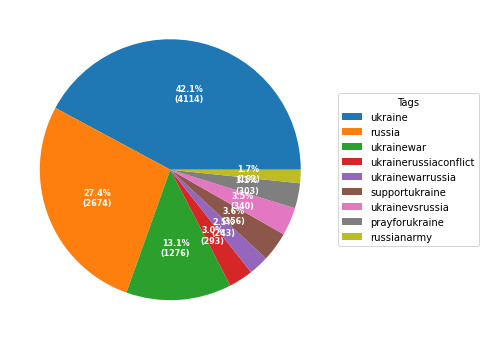

In [54]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))

data = [x["count"] for x in resData]
tags = [x["tag"] for x in resData]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, tags,
          title="Tags",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

plt.show()


Let's loo at the videos with #ukrainewar

In [26]:
query = """MATCH (v:video)--(t:tag)
WHERE t.title = 'ukrainewar'
RETURN v"""

res = graph.run(query)
resData = res.data()
resData = [json.loads(json.dumps(el["v"])) for el in resData]


def getElements(myList, tag):
    newList = []
    for el in myList:
        value = el.get(tag)
        if value:
            newList.append(int(value))
    return newList


likes = getElements(resData, "diggCount")
shares = getElements(resData, "shareCount")
comments = getElements(resData, "commentCount")
views = getElements(resData, "playCount")


In [35]:
dfLikes = pd.DataFrame(likes, columns=["value"])
dfLikes["type"] = "likes"
dfShares = pd.DataFrame(shares, columns=["value"])
dfShares["type"] = "shares"
dfComments = pd.DataFrame(comments, columns=["value"])
dfComments["type"] = "comments"
dfViews = pd.DataFrame(views, columns=["value"])
dfViews["type"] = "views"
df = pd.concat([dfLikes, dfShares, dfComments, dfViews],
               join='inner', axis=0).reset_index(drop=True)


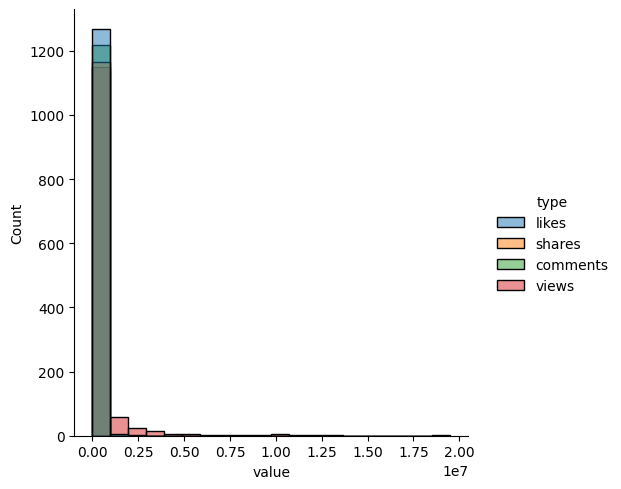

In [37]:
sns.displot(df, x="value", hue="type", bins=20)


Find the best users according to the videos

In [25]:
query = """
MATCH (u:user)-[a:author]-(v:video)-[h:has]-(t:tag)
WHERE t.title = 'ukrainewar' and v.diggCount > 7000
    RETURN u.id as user, u.followerCount as followers, count(v) as nVideos, sum(v.diggCount) as likes
ORDER BY likes DESC limit 5
"""

res = graph.run(query)
resData = res.data()

Recommended videos tags

In [18]:
queryUser = """
MATCH (u:user)-[a:author]-(v:video)-[h:has]-(t:tag)
WHERE t.title = 'ukrainewar' and v.diggCount > 7000
WITH u LIMIT 5
MATCH (u)-[r:recommends]-(newU:user)-[auth:author]-(newVideos:video)-[f:has]-(newTag:tag)
return newTag as tag
"""

queryVideos = """
MATCH (u:user)-[a:author]-(v:video)-[h:has]-(t:tag)
WHERE t.title = 'ukrainewar' and v.diggCount > 7000
WITH u LIMIT 5
MATCH (u)-[auth:author]-(newVideos:video)-[r:recommends]-(v:video)-[f:has]-(newTag:tag)
return newTag as tag
"""

res = graph.run(queryUser)
resData = res.data()

In [19]:
newTags = []
def get_tag(el):
    obj = json.loads(json.dumps(el))
    tag = obj.get("splitTitle")
    if not tag:
        tag = obj.get("title")
    return tag

for el in [get_tag(x["tag"]) for x in resData]:
    newTags.extend(el.split(" "))

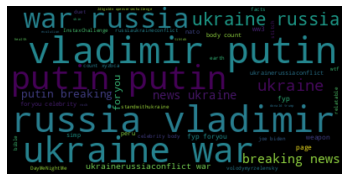

In [20]:
# Start with one review:
text = " ".join(newTags)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)
    
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [25]:
# Query for image in Gephi

In [26]:
query = """
CALL apoc.export.graphml.query("
MATCH (u:user)-[a:author]-(v:video)-[h:has]-(t:tag)
WHERE t.title = 'ukrainewar' and v.diggCount > 7000
WITH u limit 5
MATCH (u)-[r:recommends]-(othU:user)-[auth:author]-(newVideos:video)-[f:has]-(newTag:tag)
return u,r,othU,auth,newVideos,f,newTag
", "subset.graphml",
{useTypes: true, storeNodeIds:true, readLabels:true})
"""